In [18]:
# 导入所需的库和模块
import mindspore.dataset as ds
# 设置MindSpore的运行模式为图模式，这是一种高效的运行模式
import mindspore.dataset.vision.c_transforms as CV
# 定义数据集的路径
from mindspore import dtype as mstype

# 使用MindSpore的Cifar10Dataset加载CIFAR-10数据集
train_data_path = './data/flower_photos_train'
# 打印出数据集的一些信息
val_data_path = './data/flower_photos_test'


# 定义一个创建数据集的函数
def create_dataset(data_path, batch_size=18, training=True):
# 函数的参数：
# - dataset_path：数据集的路径
# - do_train：如果为True，则创建训练数据集；如果为False，则创建测试数据集
# - repeat_num：数据集的重复次数
# - batch_size：每个批次的数据量
# - target：目标设备，可以是Ascend、GPU或CPU
    """定义数据集"""

# 使用定义的函数创建训练数据集和测试数据集
    data_set = ds.ImageFolderDataset(data_path, num_parallel_workers=8, shuffle=True,
# 打印出训练数据集的一些信息
                                     class_indexing={'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3,
# 打印出测试数据集的一些信息
                                                     'tulips': 4})
# 定义MobileNetV2模型
    # 对数据进行增强操作
# 定义损失函数和优化器
    image_size = 224
# 定义模型训练的一些参数，如学习率、训练的轮次、模型保存的目录等
    mean = [0.485 * 255, 0.456 * 255, 0.406 * 255]
# 使用定义的模型、损失函数和优化器创建一个模型实例
    std = [0.229 * 255, 0.224 * 255, 0.225 * 255]
# 开始训练模型
    if training:
# 使用测试数据集评估训练好的模型
        trans = [
# 打印出模型的准确率
            CV.RandomCropDecodeResize(image_size, scale=(0.08, 1.0), ratio=(0.75, 1.333)),
            CV.RandomHorizontalFlip(prob=0.5),
            CV.Normalize(mean=mean, std=std),
            CV.HWC2CHW()
        ]
    else:
        trans = [
            CV.Decode(),
            CV.Resize(256),
            CV.CenterCrop(image_size),
            CV.HWC2CHW()
        ]

    # 实现数据的map映射、批量处理和数据重复的操作
    data_set = data_set.map(operations=trans, input_columns="image", num_parallel_workers=8)
    # 设置batch_size的大小，若最后一次抓取的样本数小于batch_size，则丢弃
    data_set = data_set.batch(batch_size, drop_remainder=True)

    return data_set


dataset_train = create_dataset(train_data_path)
dataset_val = create_dataset(val_data_path)

[WARNING] ME(48588:58212,MainProcess):2023-07-14-16:45:27.879.033 [mindspore\dataset\core\validator_helpers.py:806] 'RandomCropDecodeResize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'RandomCropDecodeResize' from mindspore.dataset.vision instead.
[WARNING] ME(48588:58212,MainProcess):2023-07-14-16:45:27.880.626 [mindspore\dataset\core\validator_helpers.py:806] 'RandomHorizontalFlip' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'RandomHorizontalFlip' from mindspore.dataset.vision instead.
[WARNING] ME(48588:58212,MainProcess):2023-07-14-16:45:27.882.125 [mindspore\dataset\core\validator_helpers.py:806] 'Normalize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Normalize' from mindspore.dataset.vision instead.
[WARNING] ME(48588:58212,MainProcess):2023-07-14-16:45:27.

Tensor of image (18, 3, 224, 224)
Labels: [3 3 2 1 1 1 3 4 2 2 4 3 2 0 2 4 1 2]


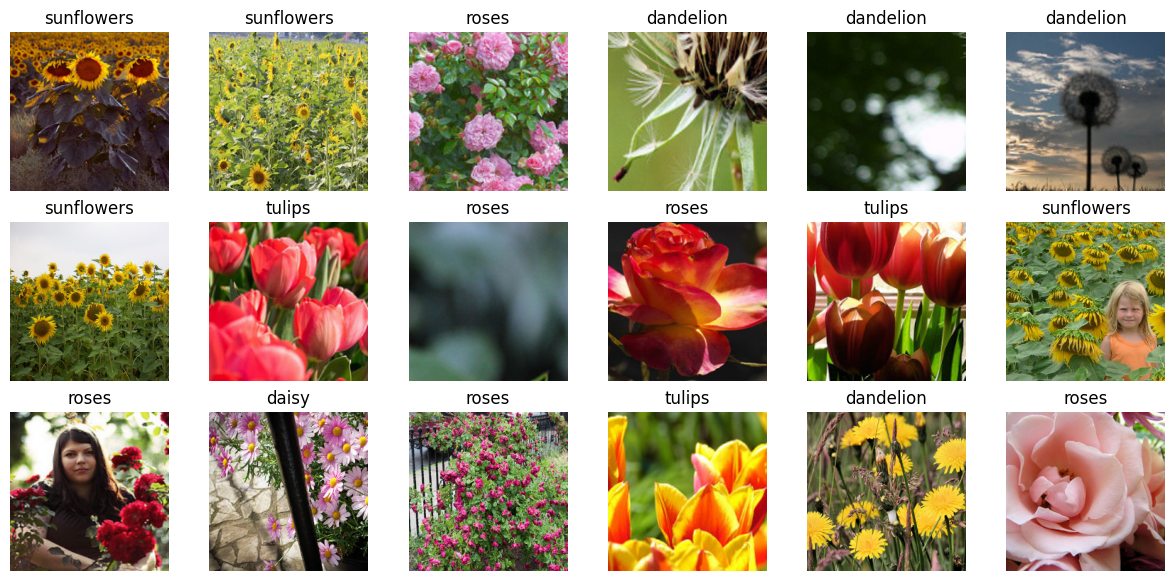

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# 使用create_dict_iterator()函数来创建一个字典迭代器，用于获取训练数据集中的下一批次数据
data = next(dataset_train.create_dict_iterator())

# 从data字典中提取出图像数据，存储在images变量中
images = data["image"]

# 从data字典中提取出图像对应的标签数据，存储在labels变量中
labels = data["label"]

# 打印图像数据的形状，用于查看每批次图像的数量以及图像的尺寸
print("Tensor of image", images.shape)

# 打印每批次图像对应的标签，用于查看图像的类别
print("Labels:", labels)

# 定义一个字典，将每个类别的标签映射为相应的类名，这里是按照文件夹名称的字母顺序为每个类别分配了一个整数标签
class_name = {0:'daisy',1:'dandelion',2:'roses',3:'sunflowers',4:'tulips'}

# 创建一个15x7大小的新的figure，用于后续的图像展示
plt.figure(figsize=(15, 7))

# 对于每批次的图像数据，分别进行处理和展示
for i in range(len(labels)):
    # 获取第i个图像数据及其对应的标签
    data_image = images[i].asnumpy()
    data_label = labels[i]
    
    # 将图像数据的维度进行转置，将通道维度移到最后，以满足matplotlib的imshow函数的输入要求
    data_image = np.transpose(data_image, (1, 2, 0))
    
    # 对图像数据进行标准化，这里的mean和std是预设的标准化参数，分别代表每个通道的平均值和标准差
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    data_image = std * data_image + mean
    
    # 对图像数据进行裁剪，保证所有的像素值都在[0, 1]范围内
    data_image = np.clip(data_image, 0, 1)
    
    # 在新的子图上绘制图像
    plt.subplot(3, 6, i + 1)
    plt.imshow(data_image)
    
    # 在子图的标题上显示图像的类名
    plt.title(class_name[int(labels[i].asnumpy())])
    
    # 隐藏子图的坐标轴
    plt.axis("off")

# 显示所有的子图
plt.show()


In [20]:
import numpy as np
import mindspore as ms
import mindspore.nn as nn
import mindspore.ops as ops


# 定义一个用于调整网络层参数的函数，使其可以被特定的数整除，如果调整后的数值小于给定的最小值或者比原始数值小了10%以上，那么会增加一个除数的数量
def _make_divisible(v, divisor, min_value=None):
    # 如果没有给定最小值，那么最小值就设定为除数
    if min_value is None:
        min_value = divisor
    # 计算新的数值，首先将v增加除数的一半，然后整除除数并乘以除数，最后保证新的数值不小于最小值
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # 确保新的数值不会比原始数值小10%以上
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

# 定义全局平均池化层，这个层会计算输入数据在空间维度上的平均值
class GlobalAvgPooling(nn.Cell):
    def __init__(self):
        super(GlobalAvgPooling, self).__init__()
        # ReduceMean操作用于计算平均值
        self.mean = ops.ReduceMean(keep_dims=False)

    def construct(self, x):
        # 计算输入数据在第2和第3个维度上的平均值，相当于在宽度和高度上做平均
        x = self.mean(x, (2, 3))
        return x

# 定义一个卷积-归一化-激活层，这个层包含一个卷积层，一个批量归一化层和一个ReLU激活层
class ConvBNReLU(nn.Cell):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1):
        super(ConvBNReLU, self).__init__()
        padding = (kernel_size - 1) // 2
        in_channels = in_planes
        out_channels = out_planes
        # 如果groups参数为1，那么创建一个普通的卷积层
        if groups == 1:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, pad_mode='pad', padding=padding)
        # 如果groups参数不为1，那么创建一个分组卷积层，这个卷积层的输入和输出通道数都是in_planes
        else:
            out_channels = in_planes
            conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, pad_mode='pad',
                             padding=padding, group=in_channels)
        # 创建一个层序列，包含卷积层，批量归一化层和ReLU激活层
        layers = [conv, nn.BatchNorm2d(out_planes), nn.ReLU6()]
        self.features = nn.SequentialCell(layers)

    def construct(self, x):
        output = self.features(x)
        return output

# 定义一个倒置残差块，这个块是MobileNetV2的基本组件，包含一个或两个卷积-归一化-激活层，以及一个卷积-归一化层
class InvertedResidual(nn.Cell):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        assert stride in [1, 2]

        # 计算扩展后的通道数
        hidden_dim = int(round(inp * expand_ratio))
        # 如果步长为1且输入和输出通道数相同，那么使用残差连接
        self.use_res_connect = stride == 1 and inp == oup

        layers = []
        # 如果扩展比例不为1，那么添加一个1x1的卷积-归一化-激活层
        if expand_ratio != 1:
            layers.append(ConvBNReLU(inp, hidden_dim, kernel_size=1))
        # 添加一个深度可分离的卷积-归一化-激活层和一个1x1的卷积-归一化层
        layers.extend([
            # dw
            ConvBNReLU(hidden_dim, hidden_dim,
                       stride=stride, groups=hidden_dim),
            # pw-linear
            nn.Conv2d(hidden_dim, oup, kernel_size=1,
                      stride=1, has_bias=False),
            nn.BatchNorm2d(oup),
        ])
        self.conv = nn.SequentialCell(layers)
        self.add = ops.Add()
        self.cast = ops.Cast()

    def construct(self, x):
        identity = x
        x = self.conv(x)
        # 如果使用残差连接，那么将输入和输出相加
        if self.use_res_connect:
            return self.add(identity, x)
        return x


class MobileNetV2Backbone(nn.Cell):
    # 定义MobileNetV2的主干网络
    def __init__(self, width_mult=1., inverted_residual_setting=None, round_nearest=8,
                 input_channel=32, last_channel=1280):
        # 初始化函数
        super(MobileNetV2Backbone, self).__init__()  # 调用父类的初始化函数
        block = InvertedResidual  # InvertedResidual类是一个堆叠的卷积块
        self.cfgs = inverted_residual_setting  # inverted_residual_setting是网络的配置参数
        if inverted_residual_setting is None:  # 如果没有给出配置，则使用默认配置
            self.cfgs = [
                [1, 16, 1, 1],
                [6, 24, 2, 2],
                [6, 32, 3, 2],
                [6, 64, 4, 2],
                [6, 96, 3, 1],
                [6, 160, 3, 2],
                [6, 320, 1, 1],
            ]

        input_channel = _make_divisible(input_channel * width_mult, round_nearest)  # 调整输入通道数
        self.out_channels = _make_divisible(last_channel * max(1.0, width_mult), round_nearest)  # 调整输出通道数
        features = [ConvBNReLU(3, input_channel, stride=2)]  # 创建第一个ConvBNReLU卷积层，步长为2
        # 构建堆叠的卷积块
        for t, c, n, s in self.cfgs:
            output_channel = _make_divisible(c * width_mult, round_nearest)  # 调整输出通道数
            for i in range(n):
                stride = s if i == 0 else 1  # 第一层使用s作为步长，其余使用1
                features.append(block(input_channel, output_channel, stride, expand_ratio=t))  # 添加卷积块到features
                input_channel = output_channel  # 更新输入通道数

        features.append(ConvBNReLU(input_channel, self.out_channels, kernel_size=1))  # 创建最后的ConvBNReLU卷积层，核大小为1
        self.features = nn.SequentialCell(features)  # 将所有卷积层组合成一个网络
        self._initialize_weights()  # 初始化权重

    def construct(self, x):
        # 网络前向传播函数
        x = self.features(x)  # 执行特征提取操作
        return x

    def _initialize_weights(self):

        self.init_parameters_data()
        for _, m in self.cells_and_names():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.set_data(ms.Tensor(np.random.normal(0, np.sqrt(2. / n),
                                                             m.weight.data.shape).astype("float32")))

                if m.bias is not None:
                    m.bias.set_data(
                        ms.numpy.zeros(m.bias.data.shape, dtype="float32"))
            elif isinstance(m, nn.BatchNorm2d):
                m.gamma.set_data(
                    ms.Tensor(np.ones(m.gamma.data.shape, dtype="float32")))
                m.beta.set_data(
                    ms.numpy.zeros(m.beta.data.shape, dtype="float32"))

    @property
    def get_features(self):
        # 提供一个公共接口返回所有特征层
        return self.features


class MobileNetV2Head(nn.Cell):
    # 定义MobileNetV2的头部网络，用于分类任务
    def __init__(self, input_channel=1280, num_classes=1000, has_dropout=False, activation="None"):
        # 初始化函数
        super(MobileNetV2Head, self).__init__()  # 调用父类的初始化函数
        head = ([GlobalAvgPooling()] if not has_dropout else
                [GlobalAvgPooling(), nn.Dropout(0.2)])  # 根据是否需要dropout创建全局平均池化层和dropout层
        self.head = nn.SequentialCell(head)  # 创建头部网络
        self.dense = nn.Dense(input_channel, num_classes, has_bias=True)  # 创建全连接层，输入通道数为input_channel，输出通道数为num_classes
        self.need_activation = True  # 是否需要激活函数的标志位
        # 根据激活函数的类型创建对应的激活层
        if activation == "Sigmoid":
            self.activation = ops.Sigmoid()
        elif activation == "Softmax":
            self.activation = ops.Softmax()
        else:
            self.need_activation = False  # 不需要激活函数
        self._initialize_weights()  # 初始化权重

    def construct(self, x):
        # 网络前向传播函数
        x = self.head(x)  # 执行头部网络的前向传播
        x = self.dense(x)  # 执行全连接层的前向传播
        if self.need_activation:  # 如果需要激活函数，则执行激活函数
            x = self.activation(x)
        return x

    def _initialize_weights(self):

        self.init_parameters_data()
        for _, m in self.cells_and_names():
            if isinstance(m, nn.Dense):
                m.weight.set_data(ms.Tensor(np.random.normal(
                    0, 0.01, m.weight.data.shape).astype("float32")))
                if m.bias is not None:
                    m.bias.set_data(
                        ms.numpy.zeros(m.bias.data.shape, dtype="float32"))


class MobileNetV2Combine(nn.Cell):
    # 定义MobileNetV2网络，包括主干网络和头部网络
    def __init__(self, backbone, head):
        # 初始化函数
        super(MobileNetV2Combine, self).__init__(auto_prefix=False)  # 调用父类的初始化函数
        self.backbone = backbone  # 主干网络
        self.head = head  # 头部网络

    def construct(self, x):
        # 网络前向传播函数
        x = self.backbone(x)  # 执行主干网络的前向传播
        x = self.head(x)  # 执行头部网络的前向传播
        return x

def mobilenet_v2(num_classes):
    # 创建MobileNetV2网络
    backbone_net = MobileNetV2Backbone()  # 创建主干网络
    head_net = MobileNetV2Head(backbone_net.out_channels,num_classes)  # 创建头部网络，输入通道数为主干网络的输出通道数，输出通道数为类别数
    return MobileNetV2Combine(backbone_net, head_net)  # 创建MobileNetV2网络，包括主干网络和头部网络


In [21]:
import mindspore
import mindspore.nn as nn
from mindspore.train import Model
from mindspore import Tensor, save_checkpoint
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor
from mindspore.train.serialization import load_checkpoint, load_param_into_net
# 创建模型,其中目标分类数为5
network = mobilenet_v2(5)

# 加载预训练权重
param_dict = load_checkpoint("./data/mobilenetv2_ascend_v170_imagenet2012_official_cv_top1acc71.88.ckpt")

# 根据修改的模型结构修改相应的权重数据
param_dict["dense.weight"] = mindspore.Parameter(Tensor(param_dict["dense.weight"][:5, :],mindspore.float32), name="dense.weight", requires_grad=True)
param_dict["dense.bias"] = mindspore.Parameter(Tensor(param_dict["dense.bias"][:5, ],mindspore.float32), name="dense.bias", requires_grad=True)

# 将修改后的权重参数加载到模型中
load_param_into_net(network, param_dict)

train_step_size = dataset_train.get_dataset_size()
epoch_size = 5
lr = nn.cosine_decay_lr(min_lr=0.0, max_lr=0.1,total_step=epoch_size * train_step_size,step_per_epoch=train_step_size,decay_epoch=200)
#定义优化器
network_opt = nn.Momentum(params=network.trainable_params(), learning_rate=0.01, momentum=0.9)

# 定义损失函数
network_loss = loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")

# 定义评价指标
metrics = {"Accuracy": nn.Accuracy()}

# 初始化模型
model = Model(network, loss_fn=network_loss, optimizer=network_opt, metrics=metrics)

# 损失值监控
loss_cb = LossMonitor(per_print_times=train_step_size)

# 模型保存参数，设置每隔多少步保存一次模型，最多保存几个模型
ckpt_config = CheckpointConfig(save_checkpoint_steps=100, keep_checkpoint_max=10)

# 模型保存，设置模型保存的名称，路径，以及保存参数
ckpoint_cb = ModelCheckpoint(prefix="mobilenet_v2", directory='./ckpt', config=ckpt_config)

print("============== Starting Training ==============")
# 训练模型，设置训练次数为5，训练集，回调函数
model.train(5, dataset_train, callbacks=[loss_cb,ckpoint_cb], dataset_sink_mode=True)
# 使用测试集进行模型评估，输出测试集的准确率
metric = model.eval(dataset_val)
print(metric)


============== Starting Training ==============
epoch: 1 step: 27, loss is 0.412544846534729
epoch: 2 step: 27, loss is 0.6225974559783936
epoch: 3 step: 27, loss is 0.631751298904419
epoch: 4 step: 27, loss is 0.4347135126590729
epoch: 5 step: 27, loss is 0.11043643951416016
{'Accuracy': 0.7777777777777778}


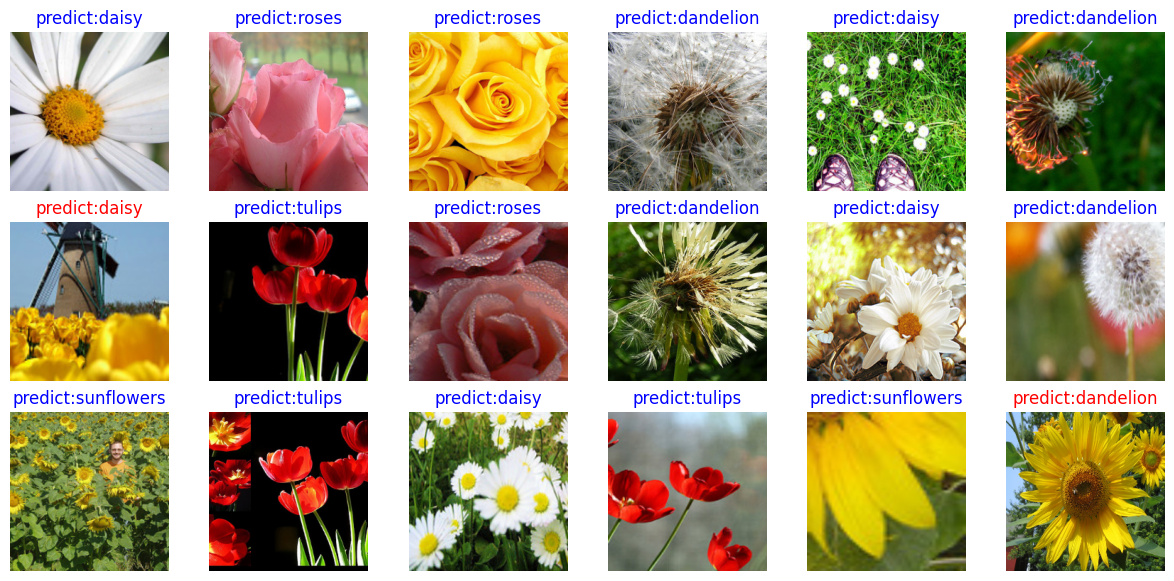

In [23]:
import matplotlib.pyplot as plt
import mindspore as ms


# 定义函数 visualize_model 用于可视化模型的预测效果
def visualize_model(best_ckpt_path, val_ds):
    num_class = 5  # 定义分类数为5，用于分类五种花卉
    net = mobilenet_v2(num_class)  # 创建MobileNetV2模型，分类数为5
    # 加载模型参数
    param_dict = ms.load_checkpoint(best_ckpt_path)  # 从指定路径加载预训练的模型参数
    ms.load_param_into_net(net, param_dict)  # 将预训练的模型参数加载到网络
    model = ms.Model(net)  # 创建Model实例
    # 加载验证集的数据进行验证
    data = next(val_ds.create_dict_iterator())  # 从验证集中获取一批数据
    images = data["image"].asnumpy()  # 将image字段从Tensor转换为numpy数组
    labels = data["label"].asnumpy()  # 将label字段从Tensor转换为numpy数组
    class_name = {0:'daisy',1:'dandelion',2:'roses',3:'sunflowers',4:'tulips'}  # 创建类别标签字典，用于后续显示
    # 预测图像类别
    output = model.predict(ms.Tensor(data['image']))  # 使用模型预测图像的类别
    pred = np.argmax(output.asnumpy(), axis=1)  # 从预测的结果中取得预测类别的最大概率索引作为预测值

    # 显示图像及图像的预测值
    plt.figure(figsize=(15, 7))  # 创建一个新的figure，并设置figure的大小
    for i in range(len(labels)):  # 遍历当前批次的每一张图像
        plt.subplot(3, 6, i + 1)  # 为当前图像设置子图位置
        # 若预测正确，显示为蓝色；若预测错误，显示为红色
        color = 'blue' if pred[i] == labels[i] else 'red'  # 若预测值与真实标签相等，设置颜色为蓝色；否则，设置颜色为红色
        plt.title('predict:{}'.format(class_name[pred[i]]), color=color)  # 设置子图的标题为预测的类别，并根据预测正确性设置颜色
        picture_show = np.transpose(images[i], (1, 2, 0))  # 将图像的维度从(C,H,W)变为(H,W,C)，以便显示
        mean = np.array([0.485, 0.456, 0.406])  # 定义均值
        std = np.array([0.229, 0.224, 0.225])  # 定义标准差
        picture_show = std * picture_show + mean  # 将图像数据反标准化
        picture_show = np.clip(picture_show, 0, 1)  # 将图像数据裁剪到[0,1]范围内
        plt.imshow(picture_show)  # 显示图像
        plt.axis('off')  # 关闭坐标轴

    plt.show()  # 显示全部图像

# 调用函数，可视化模型的预测效果
visualize_model('ckpt/mobilenet_v2-1_100.ckpt', dataset_val) 
